# Simulation

To test whether participants rely on state abstraction, we can fit the decision values associated with abstract MDP at various $\epsilon$ to behavioural data and perform model comparison to identify the $\epsilon$ value that matches participants behaviour most closely. If it's anything above 0, then we have evidence that participants rely on state abstraction. Specifically, we will fit the decision values to participants responses using a bayesian hierarchical logistic regression. Before we can actually do that, we need to come up with the specific model. Then, we need to test two things:
1. Whether it can retrieve parameters accurately 
2. Whether model comparison can discriminate between different $\epsilon$

## Bayesian logistic regression
We will use a simple hierarchical logistic model:

$$y_{i, j} = Bernoulli(p_{i, j}(accept))$$

Where:

$$p_{i, j}(accept) = \frac{1}{1+e^{\eta}}$$


$$\eta_{i, j} = \beta_{0j} + \beta_{1j}x_{i, j}$$

Where $i$ stands for trial number and $j$ for subject number and $x$ are the decision values from a model MDP. 

The $\beta$ coefficient are allowed to vary per subject:

$$\beta_{0, j} \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$\beta_{1, j} \sim \mathcal{N}(\mu_1, \sigma_1^2)$$

As with any bayesian analyses, we need to specify priors on all free parameters. In this case, we will specify priors for the group level parameters, i.e. $\mu_k$ and $\sigma_k^2$:

$$\beta_{0, j} \sim \mathcal{N}(0, 2)$$
$$\beta_{1, j} \sim \mathcal{N}(0, 2)$$

These are rather informative priors, they are based on the study on which this project is based <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1).

We will implement this model using pymc <a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2)

## Simulating data

In the first place, we want to make sure that our model is implemented correctly. We can test that easily by simulating data with known ground truth effects and test whether the model is able to accurately recover these parameters from the data (i.e. face validity). 

For that, we will simulate data by (1) generating design matrices reflecting Ott's et al.<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) original design for $j$ subjects, (2) extract the decision values for each trial from the optimal state action value function on the ground MDP (not from an abstract MDP just yet), (3) generate a response for each trial using the model formulae: $y_{i, j} = Bernoulli(\frac{1}{1+e^{\beta_{0j} + \beta_{1j}x_{i, j}}})$, where $\beta_{0j} \sim \mathcal{0, 1}$ and $\beta_{0j} \sim \mathcal{2, 1}$. If the model is working well, we would expect it to return a posterior for $\beta_0$ centered on 0 and for $\beta_1$ centered on 2, with the single participants estimates spread around these values to an extent matching a variance of 1. 

In [9]:
import numpy as np
import pandas as pd
from scipy.special import expit
import pymc as pm
import arviz as az
from scipy import stats
import warnings
# initialize numpy rng seed:
rng = np.random.default_rng(12345)
warnings.filterwarnings("ignore")

from stabst.utils import abstract2ground_value
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt

# Create task of limited energy:
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()
# Create full MDP and compute solution:
gamma = 0.99
task_mdp = MDP(task.states, task.tp, task.r, gamma, s2i=task.s2i)
_, Q_full = task_mdp.backward_induction()
# Calculate decision values
DVs = Q_full[:, 1] - Q_full[:, 0]
DVs_norm = stats.zscore(DVs)

# Generate random design matrices for simulated subjects:
n_trials = 200
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [0, 2]
betas_var = [1, 1]
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)[0]
        
        # Get the decision value:
        DV = DVs_norm[task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'DV': DV,
            'y': y
        }, index=[0])])

data = data.reset_index(drop=True)
subject_codes, subject_labels = pd.factorize(data["subject"])

## Fitting the model

Below is the pymc model specification. Note that we have added two extra parameters, $\beta_{0, offset}$ and $\beta_{1, offset}$. This is a trick called non-centered parametrization, which takes care of issues in sampling that can lead to strong divergences. These two parameters are inconsequential, what we are essentially modelling is for each participants the $\beta$ values relative to the population mean, which is anyways what we are after, and it ensures that the sampler visits parts of the space that it would have difficulties accessing otherwise. Before fitting the model, we display a graphical visualization of the parameters, and perform some prior predictive checks, i.e. plot the data yielded from our prior, to make sure we didn't implement crazy. 

Sampling: [beta_pop, sigma_pop, y, z]


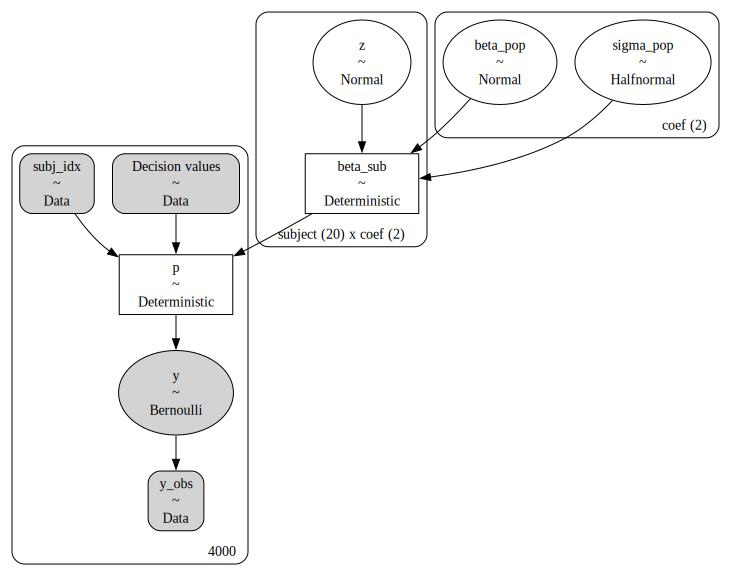

In [10]:
# Extract the data of one subject:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "subject": subj_labels,
    "coef": ["intercept", "slope"],
}

with pm.Model(coords=coords) as hierarchical_binomial_regression:
    y_obs = pm.Data("y_obs", data["y"])
    dv = pm.Data("Decision values", data["DV"])
    subj_idx = pm.Data("subj_idx", subj_idx_raw)

    # Population level priors:
    beta_pop = pm.Normal("beta_pop", mu=0, sigma=2, dims="coef")
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=2, dims="coef")
    # Non centered parametrization of within subject coefficients
    z = pm.Normal("z", 0, 1, dims=("subject", "coef"))
    beta_sub = pm.Deterministic("beta_sub", beta_pop + z * sigma_pop, dims=("subject","coef"))

    # Likelihood
    p = pm.Deterministic("p", pm.math.sigmoid(beta_sub[subj_idx, 0] + beta_sub[subj_idx, 1] * dv))
    pm.Bernoulli("y", p=p, observed=y_obs)
    idata = pm.sample_prior_predictive(draws=100)

pm.model_to_graphviz(hierarchical_binomial_regression)


### Prior predictive checks:

Sampling: [beta_pop, sigma_pop, y, z]


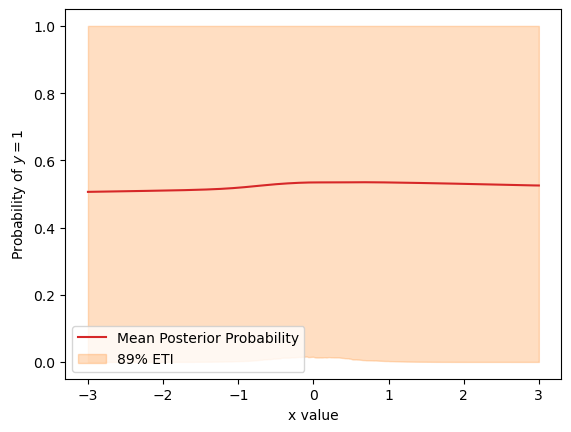

In [11]:
with hierarchical_binomial_regression:
    pm.set_data({
        "y_obs": np.random.binomial(1, 0.5, 1000),
        "Decision values": np.linspace(-3, 3, 1000),
        "subj_idx": np.zeros(1000, dtype="int32"),  # subject 0 for all rows
    })
    idata = pm.sample_prior_predictive(draws=1000)

fig, ax = plt.subplots()
hdi = az.hdi(idata.prior.p)
p_mean = idata.prior.p.mean(dim=["chain", "draw"])
ax.plot(np.linspace(-3, 3, 1000), p_mean, color="tab:red", label="Mean Posterior Probability")
ax.fill_between(np.linspace(-3, 3, 1000), *hdi.p.values.T, color="tab:orange", alpha=0.25, label="89% ETI")
ax.legend()
ax.set(ylabel="Probability of $y=1$", xlabel="x value");
plt.show()

Now let's fit the data:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


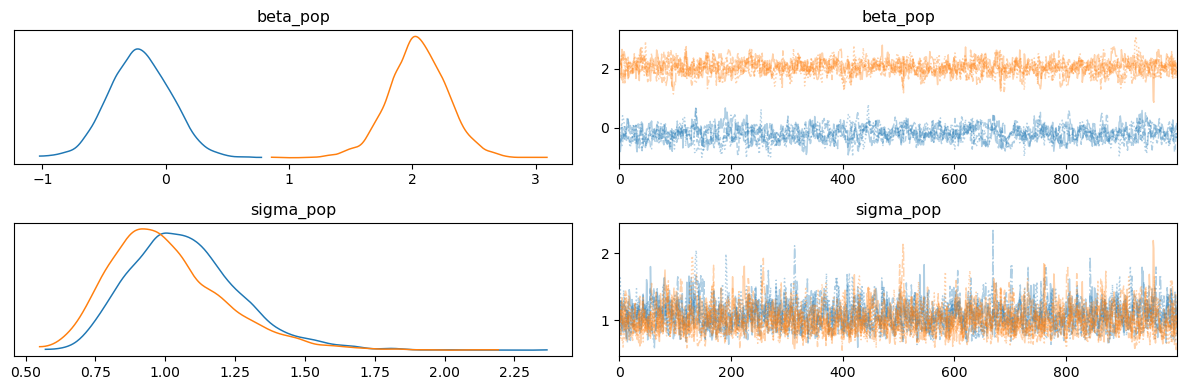

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pop[intercept],-0.209,0.248,-0.655,0.260,0.010,0.006,622.0,1013.0,1.0
beta_pop[slope],2.043,0.238,1.628,2.524,0.008,0.006,914.0,1091.0,1.0
"z[1, intercept]",2.303,0.509,1.320,3.242,0.014,0.008,1310.0,2099.0,1.0
"z[1, slope]",0.723,0.452,-0.150,1.516,0.010,0.008,2011.0,2070.0,1.0
"z[2, intercept]",-0.342,0.291,-0.857,0.225,0.010,0.005,871.0,1691.0,1.0
...,...,...,...,...,...,...,...,...,...
p[3995],0.314,0.042,0.237,0.394,0.001,0.001,3737.0,3612.0,1.0
p[3996],0.835,0.041,0.756,0.906,0.001,0.001,4024.0,3041.0,1.0
p[3997],0.375,0.043,0.298,0.457,0.001,0.001,3778.0,3596.0,1.0
p[3998],0.242,0.041,0.169,0.320,0.001,0.001,3850.0,3818.0,1.0


In [12]:
with hierarchical_binomial_regression:
    pm.set_data({"y_obs": data["y"],
                 "Decision values": data["DV"], 
                 "subj_idx": subj_idx_raw})
    idata = pm.sample(1000, tune=1000)

az.plot_trace(idata, var_names=["beta_pop", "sigma_pop"], combined=True)
plt.tight_layout()
plt.show()
az.summary(idata)

The results highlight that we are well able to retrieve the parameters we have injected in the data: the effect of decision value is close to 2, which is exactly what we have set. Now, let's try to simulate data based on decision values associated with state abstraction representation of the task. 

# Simulating data with state abstraction plan:

Now that we have established that our model is able to retrive paramters adequatly, we need to test whether we can discriminate between different models. Here models refer to the MDP at various levels of abstraction from which we derive our decision values. The overall goal of the project is to test whether participants rely on state abstraction. But if it turns out that the decision values yielded by different abstracted models are too similar from each other and that when we compare models we get complete overlap between different levels of abstraction, we wouldn't be in too good a position. 

To test separability of the various model, we will (1) simulate data from a model at a given abstraction level, (2) fit models with different abstraction levels and (3) compare the models to test whether the model from which the data were generated can be clearly separated from the other. 

## Generating decision values at abstraction levels
First, we load the bisimulation distance matrix generated in the previous notebook. Based on it, we will generate decision values by reducing the MDP at different $\epsilon$ levels, computing the optimal state action value function using dynamic programing and project back the results on the full MDP to obtain the decision value associated with each state:

In [13]:
# Load the distance matrix:
states_dist_mat = np.load(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy')

# Compute decision values associated with different abstraction levels:
DVs = dict()
sample_eps = np.sort(np.unique(np.round(states_dist_mat, decimals=3)))
n_states = len(task_mdp.states)
abstraction_distances = []
for eps in sample_eps: #unique_dist:
    # Find states clusters
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=states_dist_mat)
    # Skip any eps that doesn't decrease the size of the MDP by 10 states
    if n_states - len(abstract_mdp.states) < 10:
        continue
    else:
        n_states = len(abstract_mdp.states)
        abstraction_distances.append(eps)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to full space:
    V, Q = abstract2ground_value(class_of_state, V_R, Q_R)
    DVs[f'eps: {eps}'] = stats.zscore(Q[:, 1] - Q[:, 0])


## Simulating data
To test the separability of the decision values of different models, we will simulate data based on the decision values of one model (i.e. abstract MDP at a particular $\epsilon$):

In [14]:
# Simulate data:
# Generate random design matrices for simulated subjects:
n_trials = 200
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)
sim_dv_eps = np.random.choice(abstraction_distances, 1)

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [0, 2]
betas_var = [1, 1]
decision_noise = 1
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)[0]
        
        # Get the decision value:
        DV = DVs[f'eps: {sim_dv_eps[0]}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV + np.random.normal(0, decision_noise, size=1)))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'y': y,
            **{f'DV, eps={eps}': DVs[f'eps: {eps}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]] 
            for eps in abstraction_distances}
        }, index=[0])])

data = data.reset_index(drop=True)
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

## Fitting the model:
Now that we have generated data from one specific abstraction level, we can fit the models of all abstraction levels. We can then perform model comparison. Ideally, the model with the decision value from the abstraction level used to simulate the data should be better than the other, and also, different models should be discriminable from each other. 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


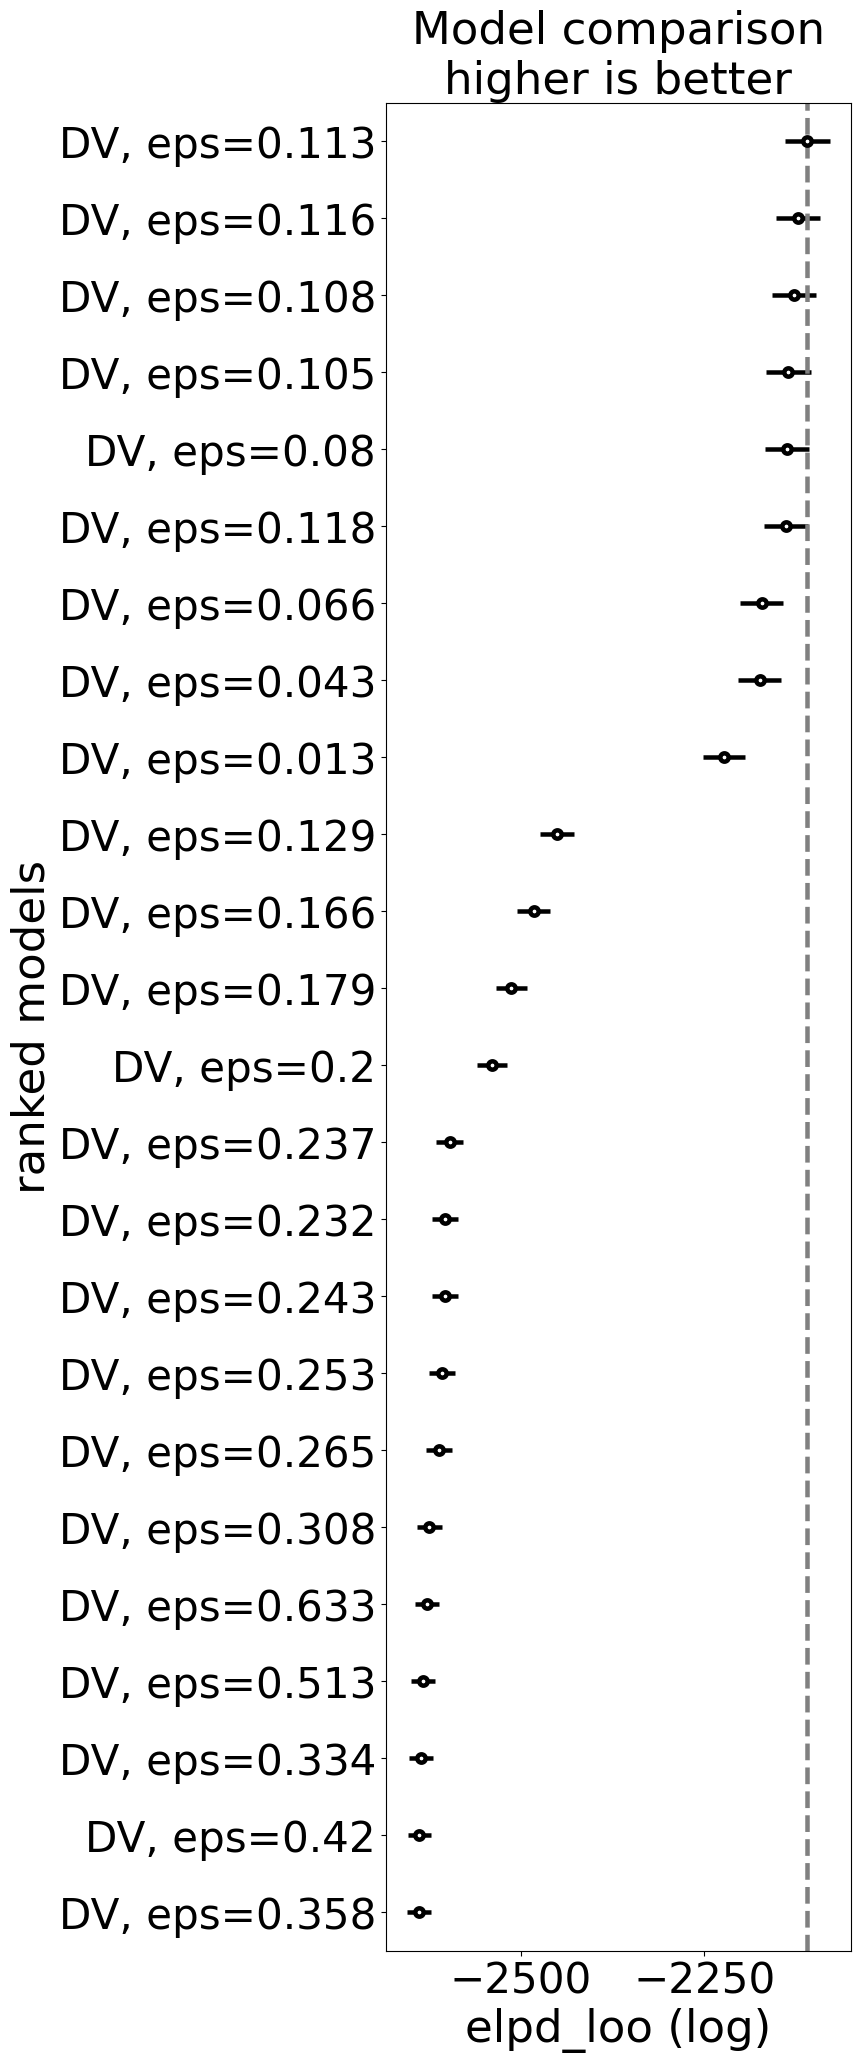

In [15]:
# Fit models at all epsilons:
traces = dict()

for eps in abstraction_distances:
    with hierarchical_binomial_regression:
        pm.set_data({"y_obs": data["y"],
                    "Decision values": data[f'DV, eps={eps}'], 
                    "subj_idx": subj_idx_raw})
        traces[f'DV, eps={eps}'] = pm.sample(1000, tune=1000, idata_kwargs={"log_likelihood": True})
# Compare models:
model_comparison = az.compare(traces)

# Plot the results of the model comparison:
az.plot_compare(model_comparison);

In [16]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"DV, eps=0.113",0,-2109.512357,36.298786,0.000000,9.606497e-01,30.576607,0.000000,False,log
"DV, eps=0.116",1,-2121.917684,36.545844,12.405326,1.012823e-12,30.471249,3.725255,False,log
"DV, eps=0.108",2,-2127.062984,36.550762,17.550627,0.000000e+00,30.358054,6.231388,False,log
"DV, eps=0.105",3,-2134.957275,36.913706,25.444918,0.000000e+00,30.250252,7.265236,False,log
"DV, eps=0.08",4,-2137.477692,36.513392,27.965335,0.000000e+00,30.017319,7.398404,False,log
"DV, eps=0.118",5,-2137.993838,36.962648,28.481481,0.000000e+00,30.252584,7.479756,False,log
"DV, eps=0.066",6,-2171.693575,36.792328,62.181218,3.935033e-02,29.772348,11.580499,False,log
"DV, eps=0.043",7,-2174.230357,36.331171,64.718000,0.000000e+00,29.710177,11.765625,False,log
"DV, eps=0.013",8,-2222.550267,36.278277,113.037910,0.000000e+00,28.771931,14.572929,False,log
"DV, eps=0.129",9,-2450.189110,33.859528,340.676753,0.000000e+00,23.195070,23.850423,False,log


We can see a clear separation patter. The Decision values used to generate the data are clearly better than all other. In addition, the model comparison reveals that all $\epsilon$ can be easily separated from another, which is quite promising. 

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Ott, F., Legler, E., & Kiebel, S. J. (2022). Forward planning driven by context-dependant conflict processing in anterior cingulate cortex. NeuroImage, 256, 119222. DOI: https://doi.org/10.1016/j.neuroimage.2022.119222

<a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 DOI: 10.7717/peerj-cs.55.